### LLM Inference Benchmarking Assignment (25 points)

#### Overview
In this assignment, you will learn how to benchmark Large Language Model (LLM) inference using vLLM, a high-performance inference engine. You will use a small model (OPT-125M) to understand the basics of throughput measurement and the impact of different parameters on inference speed.

#### Environment Setup

- Successfully install all required packages (2 points)


First, install the required packages:

In [1]:
!pip install "numpy<2"
!pip install transformers torch pandas matplotlib seaborn vllm

Import the necessary libraries:

In [2]:
# Import necessary libraries
import dataclasses
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
import gc
import torch

print("All libraries imported successfully!")

INFO 11-18 06:52:03 [__init__.py:216] Automatically detected platform cuda.


2025-11-18 06:52:04.539482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763448724.563899    6422 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763448724.573948    6422 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

All libraries imported successfully!


#### Part 1: Creating Sample Requests

- Implement the create_synthetic_requests function correctly (5 points)

We'll create a function to generate sample requests for benchmarking:

In [3]:
import random

@dataclasses.dataclass
class SampleRequest:
    """A class representing a single inference request for benchmarking."""
    prompt: str
    prompt_len: int
    expected_output_len: int

def create_synthetic_requests(
    tokenizer,
    num_requests: int,
    input_len: int,
    output_len: int
) -> List[SampleRequest]:
    """Create synthetic requests for benchmarking.

    Args:
        tokenizer: The tokenizer to use
        num_requests: Number of requests to generate
        input_len: Desired input length in tokens
        output_len: Desired output length in tokens

    Returns:
        List of SampleRequest objects
    """
    requests = []

    prompts = [
        "Tell me about the difference between recurrent neural networks and bidirectional long short term memory networks?",
        "Describe the entire history of the planet Earth?",
        "What is the source of the entire worlds' problems?",
        "Is it true that P Diddy killed Tupac and Biggie and what evidence is there confirming this?",
        "Is Angel Reese really bad at basketball or do people just hate her for no reason?",
        "How can I engineer a newborn child to be exactly like Lebron James?",
        "What's the best fried chicken spot in the entire USA?",
        "Why did the Nation of Islam team up with the CIA to murder Malcolm X?",
        "Did Sony pay a doctor to prescribe drugs to kill Michael Jackson on purpose?",
        "Based on all the existing evidence out there, do you think Deshaun Watson should be in jail?"
    ]

    prompt_ending = " Please answer this question thoroughly and provide detailed explanation and analysis to back up your answer."

    filler = ["um", "uh", "er", "ah", "like", "you know", "well", "so", "I mean", "basically", "actually", "literally", "seriously", "totally", "right", "okay", "mhm", "uh huh", "anyway", "just", "kind of", "sort of", "I guess", "I suppose", "you see", "at the end of the day", "believe me", "for what it's worth", "needless to say", "hmm"]

    for i in range(num_requests):
        prompt = prompts[i % len(prompts)] + prompt_ending
        
        while len(tokenizer.encode(prompt)) < input_len:
            prompt += " "
            prompt += random.choice(filler)

        tokens = tokenizer.encode(prompt)[:input_len]
        prompt = tokenizer.decode(tokens)
            
    
        requests.append(SampleRequest(
            prompt=prompt,
            prompt_len=len(tokens),
            expected_output_len=output_len
        ))

    return requests

#### Part 2: Implementing the Benchmark
- Implement the run_benchmark function correctly (8 points)

Create the main benchmarking function:

In [4]:
def run_benchmark(
    requests: List[SampleRequest],
    model_name: str,
    tensor_parallel_size: int = 1,
    gpu_memory_utilization: float = 0.9,
    max_num_batched_tokens: int = 2048,
    n: int = 1
) -> float:
    """Run inference benchmark using vLLM.

    Args:
        requests: List of requests to process
        model_name: Name of the model to benchmark
        tensor_parallel_size: Number of GPUs for tensor parallelism
        gpu_memory_utilization: Target GPU memory utilization
        max_num_batched_tokens: Maximum number of tokens in a batch
        n: Number of sequences to generate per prompt

    Returns:
        Elapsed time in seconds
    """
    
    llm = LLM(
        model=model_name,
        tensor_parallel_size=tensor_parallel_size,
        gpu_memory_utilization=gpu_memory_utilization,
        max_num_batched_tokens=max_num_batched_tokens
    )

    prompts = [req.prompt for req in requests]
    
    sampling_params = SamplingParams(
        temperature=0.0,
        max_tokens=requests[0].expected_output_len,
        n=n,
        ignore_eos=True 
    )

    llm.generate(prompts[0], sampling_params)

    start_time = time.time()
    outputs = llm.generate(prompts, sampling_params)
    elapsed_time = time.time() - start_time

    del llm
    gc.collect()
    torch.cuda.empty_cache()

    return elapsed_time
    

#### Part 3: Running the Benchmark (15 points)

- Experiments and Analysis (10 points)

  - Run the benchmark with different batch sizes (2 points)

  - Run the benchmark with different input/output lengths (2 points)


In [5]:
def experiment_batch_sizes(model_name: str, batch_sizes: List[int]) -> pd.DataFrame:
    """Run benchmark with different batch sizes.

    Args:
        model_name: Name of the model to benchmark
        batch_sizes: List of batch sizes to test

    Returns:
        DataFrame with results
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    results = []
    
    for batch_size in batch_sizes:
        requests = create_synthetic_requests(tokenizer, 50, 128, 128)
        elapsed = run_benchmark(requests, model_name, max_num_batched_tokens=batch_size)
        
        total_tokens = sum(r.prompt_len + r.expected_output_len for r in requests)
        throughput = total_tokens / elapsed
        
        results.append({
            'batch_size': batch_size,
            'throughput': throughput,
            'elapsed_time': elapsed
        })
    
    return pd.DataFrame(results)

In [6]:
def experiment_sequence_lengths(model_name: str, lengths: List[int]) -> pd.DataFrame:
    """Run benchmark with different input/output lengths.

    Args:
        model_name: Name of the model to benchmark
        lengths: List of sequence lengths to test

    Returns:
        DataFrame with results
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    results = []
    
    for length in lengths:
        requests = create_synthetic_requests(tokenizer, 50, length, length)
        elapsed = run_benchmark(requests, model_name)
        
        total_tokens = sum(r.prompt_len + r.expected_output_len for r in requests)
        throughput = total_tokens / elapsed
        
        results.append({
            'sequence_length': length,
            'throughput': throughput,
            'elapsed_time': elapsed
        })
    
    return pd.DataFrame(results)

  - Run the benchmark with different numbers of requests (2 points)


In [7]:
def experiment_num_requests(model_name: str, request_counts: List[int]) -> pd.DataFrame:
    """Run benchmark with different numbers of requests.

    Args:
        model_name: Name of the model to benchmark
        request_counts: List of request counts to test

    Returns:
        DataFrame with results
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    results = []
    
    for count in request_counts:
        requests = create_synthetic_requests(tokenizer, count, 128, 128)
        elapsed = run_benchmark(requests, model_name)
        
        total_tokens = sum(r.prompt_len + r.expected_output_len for r in requests)
        throughput = total_tokens / elapsed
        
        results.append({
            'num_requests': count,
            'throughput': throughput,
            'elapsed_time': elapsed
        })
    
    return pd.DataFrame(results)

  - Create a graph showing the relationship between batch size and throughput (2 points)

Now let's put everything together and run the benchmark:


Running batch size experiments...
INFO 11-18 07:01:12 [utils.py:233] non-default args: {'max_num_batched_tokens': 1024, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:01:13 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:01:13 [model.py:1510] Using max model len 2048
INFO 11-18 07:01:13 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=1024.


2025-11-18 07:01:19.669352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449279.692327    7967 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449279.700060    7967 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:01:25 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:27 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:27 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:01:39.534502610 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:01:49.545189927 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:49 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=7967) WARNING 11-18 07:01:49 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:49 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.56it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.56it/s]
(EngineCore_DP0 pid=7967) 


(EngineCore_DP0 pid=7967) INFO 11-18 07:01:50 [default_loader.py:267] Loading weights took 0.29 seconds
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:51 [gpu_model_runner.py:2653] Model loading took 0.2405 GiB and 0.805210 seconds
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:54 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:54 [backends.py:559] Dynamo bytecode transform time: 2.43 s
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:54 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.296 s
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:55 [monitor.py:34] torch.compile takes 2.43 s in total
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:56 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:56 [kv_cache_utils.py:1087] GPU KV cache size: 364,880 tokens
(EngineCore_DP0 pid=7967) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 61.67it/s]


(EngineCore_DP0 pid=7967) INFO 11-18 07:01:58 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=7967) INFO 11-18 07:01:58 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.91 seconds
INFO 11-18 07:01:59 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:02:11.674677223 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:02:12 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:02:13 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:02:13 [model.py:1510] Using max model len 2048
INFO 11-18 07:02:13 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:02:18.697723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449338.722892    8056 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449338.731182    8056 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:02:24 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:26 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:26 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:02:38.516344655 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:02:48.522151424 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:48 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8056) WARNING 11-18 07:02:48 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:48 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.63it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.63it/s]
(EngineCore_DP0 pid=8056) 


(EngineCore_DP0 pid=8056) INFO 11-18 07:02:49 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:50 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.783940 seconds
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:53 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:53 [backends.py:559] Dynamo bytecode transform time: 2.41 s
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:53 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.287 s
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:54 [monitor.py:34] torch.compile takes 2.41 s in total
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:55 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:55 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8056) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 62.15it/s]


(EngineCore_DP0 pid=8056) INFO 11-18 07:02:57 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8056) INFO 11-18 07:02:57 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.87 seconds
INFO 11-18 07:02:58 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:03:09.025366811 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


Running sequence length experiments...
INFO 11-18 07:03:10 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:03:11 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:03:11 [model.py:1510] Using max model len 2048
INFO 11-18 07:03:11 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:03:16.946941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449396.970434    8145 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449396.978339    8145 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:03:23 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:24 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:24 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:03:36.748873536 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:03:46.759671158 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:46 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8145) WARNING 11-18 07:03:46 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:46 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.67it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.67it/s]
(EngineCore_DP0 pid=8145) 


(EngineCore_DP0 pid=8145) INFO 11-18 07:03:48 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:48 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.872040 seconds
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:51 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:51 [backends.py:559] Dynamo bytecode transform time: 2.40 s
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:52 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.295 s
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:52 [monitor.py:34] torch.compile takes 2.40 s in total
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:53 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:53 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8145) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 63.59it/s]


(EngineCore_DP0 pid=8145) INFO 11-18 07:03:55 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8145) INFO 11-18 07:03:55 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.84 seconds
INFO 11-18 07:03:56 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:04:03.377694046 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:04:04 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:04:04 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:04:04 [model.py:1510] Using max model len 2048
INFO 11-18 07:04:04 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:04:10.042433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449450.065344    8234 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449450.073067    8234 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:04:16 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:17 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:17 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:04:29.885635381 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:04:39.896289603 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:39 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8234) WARNING 11-18 07:04:39 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:39 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.64it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.64it/s]
(EngineCore_DP0 pid=8234) 


(EngineCore_DP0 pid=8234) INFO 11-18 07:04:41 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:41 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.826752 seconds
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:44 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:44 [backends.py:559] Dynamo bytecode transform time: 2.42 s
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:45 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.286 s
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:45 [monitor.py:34] torch.compile takes 2.42 s in total
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:46 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:46 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8234) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 61.86it/s]


(EngineCore_DP0 pid=8234) INFO 11-18 07:04:48 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8234) INFO 11-18 07:04:48 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.89 seconds
INFO 11-18 07:04:49 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:04:57.833030545 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:04:59 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:04:59 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:04:59 [model.py:1510] Using max model len 2048
INFO 11-18 07:04:59 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:05:04.912437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449504.935539    8323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449504.943544    8323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:05:11 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:12 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:12 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:05:24.748137219 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:05:34.758952082 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:34 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8323) WARNING 11-18 07:05:34 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:34 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.62it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.61it/s]
(EngineCore_DP0 pid=8323) 


(EngineCore_DP0 pid=8323) INFO 11-18 07:05:35 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:36 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.767125 seconds
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:39 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:39 [backends.py:559] Dynamo bytecode transform time: 2.45 s
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:40 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.290 s
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:40 [monitor.py:34] torch.compile takes 2.45 s in total
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:41 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:41 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8323) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 62.74it/s]


(EngineCore_DP0 pid=8323) INFO 11-18 07:05:43 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8323) INFO 11-18 07:05:43 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.93 seconds
INFO 11-18 07:05:44 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:05:56.501768524 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


Running request count experiments...
INFO 11-18 07:05:57 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:05:57 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:05:57 [model.py:1510] Using max model len 2048
INFO 11-18 07:05:57 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:06:03.249311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449563.272089    8412 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449563.279675    8412 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:06:09 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:10 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:10 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:06:22.051050995 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:06:32.061707194 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:32 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8412) WARNING 11-18 07:06:33 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:33 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.63it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.63it/s]
(EngineCore_DP0 pid=8412) 


(EngineCore_DP0 pid=8412) INFO 11-18 07:06:34 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:35 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.758835 seconds
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:37 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:37 [backends.py:559] Dynamo bytecode transform time: 2.43 s
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:38 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.287 s
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:38 [monitor.py:34] torch.compile takes 2.43 s in total
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:39 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:40 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8412) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 62.56it/s]


(EngineCore_DP0 pid=8412) INFO 11-18 07:06:41 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8412) INFO 11-18 07:06:41 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.94 seconds
INFO 11-18 07:06:42 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:06:50.178353701 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:06:52 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:06:52 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:06:52 [model.py:1510] Using max model len 2048
INFO 11-18 07:06:52 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:06:58.161247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449618.184488    8501 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449618.192179    8501 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:07:04 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:05 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:05 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:07:17.065260943 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:07:27.076145303 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:27 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8501) WARNING 11-18 07:07:28 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:28 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.61it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.61it/s]
(EngineCore_DP0 pid=8501) 


(EngineCore_DP0 pid=8501) INFO 11-18 07:07:29 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:30 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.880920 seconds
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:33 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:33 [backends.py:559] Dynamo bytecode transform time: 2.45 s
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:33 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.299 s
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:33 [monitor.py:34] torch.compile takes 2.45 s in total
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:34 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:35 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8501) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 62.88it/s]


(EngineCore_DP0 pid=8501) INFO 11-18 07:07:37 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8501) INFO 11-18 07:07:37 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.95 seconds
INFO 11-18 07:07:38 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:07:49.082965363 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:07:51 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:07:52 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:07:52 [model.py:1510] Using max model len 2048
INFO 11-18 07:07:52 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:07:57.640620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449677.664006    8590 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449677.671609    8590 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:08:03 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:05 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:05 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:08:17.470442149 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:08:27.481195701 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:27 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8590) WARNING 11-18 07:08:27 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:27 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.64it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.63it/s]
(EngineCore_DP0 pid=8590) 


(EngineCore_DP0 pid=8590) INFO 11-18 07:08:28 [default_loader.py:267] Loading weights took 0.28 seconds
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:29 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.774182 seconds
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:32 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:32 [backends.py:559] Dynamo bytecode transform time: 2.41 s
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:32 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.290 s
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:33 [monitor.py:34] torch.compile takes 2.41 s in total
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:34 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:34 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8590) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 63.14it/s]


(EngineCore_DP0 pid=8590) INFO 11-18 07:08:36 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8590) INFO 11-18 07:08:36 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.85 seconds
INFO 11-18 07:08:37 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/100 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/100 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:08:57.552513379 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:09:00 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:09:00 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:09:00 [model.py:1510] Using max model len 2048
INFO 11-18 07:09:00 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:09:06.359321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449746.383026    8679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449746.390753    8679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:09:12 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:14 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:14 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:09:25.226413113 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:09:35.237144579 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:35 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8679) WARNING 11-18 07:09:36 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:36 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.62it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.61it/s]
(EngineCore_DP0 pid=8679) 


(EngineCore_DP0 pid=8679) INFO 11-18 07:09:37 [default_loader.py:267] Loading weights took 0.29 seconds
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:38 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.771048 seconds
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:41 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:41 [backends.py:559] Dynamo bytecode transform time: 2.44 s
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:41 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.292 s
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:41 [monitor.py:34] torch.compile takes 2.44 s in total
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:42 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:43 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8679) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 62.42it/s]


(EngineCore_DP0 pid=8679) INFO 11-18 07:09:45 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8679) INFO 11-18 07:09:45 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.95 seconds
INFO 11-18 07:09:45 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:10:18.783044149 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


INFO 11-18 07:10:25 [utils.py:233] non-default args: {'max_num_batched_tokens': 2048, 'disable_log_stats': True, 'model': 'facebook/opt-125m'}
INFO 11-18 07:10:25 [model.py:547] Resolved architecture: OPTForCausalLM
INFO 11-18 07:10:25 [model.py:1510] Using max model len 2048
INFO 11-18 07:10:25 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=2048.


2025-11-18 07:10:31.214035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763449831.237091    8768 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763449831.244741    8768 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


INFO 11-18 07:10:37 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=8768) INFO 11-18 07:10:39 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=8768) INFO 11-18 07:10:39 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=No

[W1118 07:10:50.120223089 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1118 07:11:00.130929409 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:00 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=8768) WARNING 11-18 07:11:01 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:01 [gpu_model_runner.py:2

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.58it/s]
Loading pt checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.58it/s]
(EngineCore_DP0 pid=8768) 


(EngineCore_DP0 pid=8768) INFO 11-18 07:11:02 [default_loader.py:267] Loading weights took 0.29 seconds
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:03 [gpu_model_runner.py:2653] Model loading took 0.2393 GiB and 0.761851 seconds
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:05 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/932ffef25e/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:05 [backends.py:559] Dynamo bytecode transform time: 2.42 s
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:06 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.288 s
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:06 [monitor.py:34] torch.compile takes 2.42 s in total
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:07 [gpu_worker.py:298] Available KV cache memory: 12.53 GiB
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:08 [kv_cache_utils.py:1087] GPU KV cache size: 364,864 tokens
(EngineCore_DP0 pid=8768) INFO 11-18 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 61.90it/s]


(EngineCore_DP0 pid=8768) INFO 11-18 07:11:10 [gpu_model_runner.py:3480] Graph capturing finished in 2 secs, took 0.19 GiB
(EngineCore_DP0 pid=8768) INFO 11-18 07:11:10 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.93 seconds
INFO 11-18 07:11:10 [llm.py:306] Supported_tasks: ['generate']


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/500 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/500 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[rank0]:[W1118 07:12:24.190660733 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


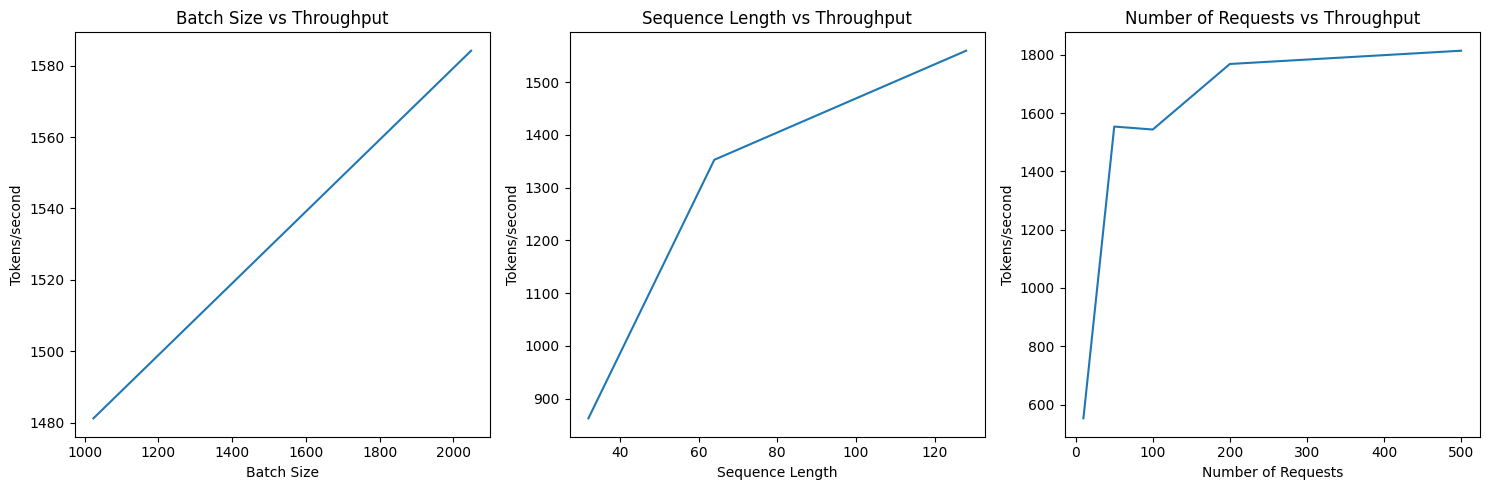

In [10]:
def run_all_experiments(model_name: str = "facebook/opt-125m"):
    """Run all experiments and create visualizations."""

    # Experiment configurations
    batch_sizes = [1024, 2048]
    sequence_lengths = [32, 64, 128]
    request_counts = [10, 50, 100, 200, 500]

    # Run experiments
    print("Running batch size experiments...")
    batch_results = experiment_batch_sizes(model_name, batch_sizes)

    print("Running sequence length experiments...")
    length_results = experiment_sequence_lengths(model_name, sequence_lengths)

    print("Running request count experiments...")
    request_results = experiment_num_requests(model_name, request_counts)

    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Batch size vs throughput
    plt.subplot(1, 3, 1)
    sns.lineplot(data=batch_results, x='batch_size', y='throughput')
    plt.title('Batch Size vs Throughput')
    plt.xlabel('Batch Size')
    plt.ylabel('Tokens/second')

    # Sequence length vs throughput
    plt.subplot(1, 3, 2)
    sns.lineplot(data=length_results, x='sequence_length', y='throughput')
    plt.title('Sequence Length vs Throughput')
    plt.xlabel('Sequence Length')
    plt.ylabel('Tokens/second')

    # Number of requests vs throughput
    plt.subplot(1, 3, 3)
    sns.lineplot(data=request_results, x='num_requests', y='throughput')
    plt.title('Number of Requests vs Throughput')
    plt.xlabel('Number of Requests')
    plt.ylabel('Tokens/second')

    plt.tight_layout()
    plt.show()

    return batch_results, length_results, request_results

# Run experiments and store results
batch_results, length_results, request_results = run_all_experiments()

In [11]:
print(batch_results)
print(length_results)
print(request_results)

   batch_size   throughput  elapsed_time
0        1024  1481.249009      8.641356
1        2048  1584.172501      8.079928
   sequence_length   throughput  elapsed_time
0               32   862.707103      3.709254
1               64  1352.743424      4.731126
2              128  1559.473363      8.207899
   num_requests   throughput  elapsed_time
0            10   552.875013      4.630341
1            50  1553.687925      8.238463
2           100  1543.557289     16.585066
3           200  1768.359138     28.953395
4           500  1813.848725     70.568178


  - Write a clear analysis of the results (2 points)


2.3.3 Experiments and Analysis

Parameter Studies

Batch size experiments: To vary the batch size, I just varied the max_num_batched_tokens argument passed when intializing the LLM. Since the sequence length was set to 128 for input and output in the batch size experiments, when max_num_batched_tokens = 1024 then the number of requests the LLM processes together is 1024 / 128 = 8 and when max_num_batched_tokens = 2048 then the number of requests the LLM processes together is 2048 / 128 = 16. From the above visualization of batch size vs. throughput and the above display of the dataframe for the batch size experiment results, we can see that for the two batch sizes tested(1024, 2048) the throughput increases slightly. Maybe the throughput will increase more rapidly for larger batch sizes but unfortunately whenever I tested larger batch sizes, I kept getting Out of Memory errors.

Input/output length experiments: From the above visualization of sequence length vs. throughput and the above display of the dataframe for the sequence length experiment results, we can clearly see that throughput increases with sequence length which means that the GPUs are getting utilized better as the sequence length increases as well. Although the elapsed time of each run increases as sequence length increases due to the LLM having to handle more tokens, the GPU is utilized more efficiently as seen in the increases in throughput.

Request count experiments:  From the above visualization of number of requests vs. throughput and the above display of the dataframe for the request count experiment results, we can clearly see that throughput generally improves as the number of requests increases. However, it's also clearly evident that the throughput increase slows down after number of requests = 50. So the LLM definitely is able to scale efficiently with more requests up to a certain point after which the throughput gains kind of slow down since the GPUs are probably already being fully utilized.